<a href="https://colab.research.google.com/github/rahulgithubrds/Python-Machine-Learning-Analysis/blob/master/SentimentAnalysis/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

## Download necessary NLTK components for the corpus and stop words

In [ ]:
# Download necessary NLTK components for the corpus and stop words
print("--- 1. NLTK Setup ---")
try:
  nltk.download(['movie_reviews', 'stopwords'], quiet=True)
except Exception as e:
  print(f'Error in download NLTK: {e}')

from nltk.corpus import movie_reviews
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

--- 1. NLTK Setup ---


Data Preperation (Corpus to Skitlearn format

In [ ]:
pos_files = movie_reviews.fileids('pos')
neg_files = movie_reviews.fileids('neg')

documents = []
labels = []

# Collect all positive reviews (label 1)
for fileid in pos_files:
  review_text = ' '.join(movie_reviews.words(fileid))
  documents.append(review_text)
  labels.append(1)

for fileid in neg_files:
  review_text = ' '.join(movie_reviews.words(fileid))
  documents.append(review_text)
  labels.append(0)

# Create a DataFrame for inspection (optional, but highly recommended in a notebook)
data = pd.DataFrame({'review': documents, 'sentiment': labels})
print(data.head(5))

print(f'Total review loaded: {len(data)}')
print("Sentiment distribution: ")
print(data['sentiment'].value_counts())

# Shuffle the data to ensure training/test split is unbiased
combined = list(zip(documents, labels))
random.shuffle(combined)
X_raw, y = zip(*combined)
X_raw = list(X_raw)
y = list(y)


                                              review  sentiment
0  films adapted from comic books have had plenty...          1
1  every now and then a movie comes along from a ...          1
2  you ' ve got mail works alot better than it de...          1
3  " jaws " is a rare film that grabs your attent...          1
4  moviemaking is a lot like being the general ma...          1
Total review loaded: 2000
Sentiment distribution: 
sentiment
1    1000
0    1000
Name: count, dtype: int64


Data Splitting and Feature Engineering (TF-IDF)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Training set size: {len(X_train)} reviews')
print(f'Test set size: {len(X_test)} reviews')

# Feature Engineering
# TfidfVectorizer converts text into a matrix of token counts and frequencies.
vectorizer = TfidfVectorizer(
    max_features = 2000,     # Consider only the top 2000 most frequent words
    ngram_range = (1, 2),
    stop_words = list(STOPWORDS),
    strip_accents = 'unicode'
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f'Vacabulary szie (max_feature) {len(vectorizer.vocabulary_)}')
print(f'Shape of training feature matrix (Reviews x Features): {X_train_vec.shape}')

Training set size: 1600 reviews
Test set size: 400 reviews
Vacabulary szie (max_feature) 2000
Shape of training feature matrix (Reviews x Features): (1600, 2000)


###  Evaluate, Predict, Accuracy, and Visualization

Model training complete
Test Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.77      0.85      0.81       200
Positive (1)       0.83      0.75      0.79       200

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400


Visualizing Confusion Matrix...


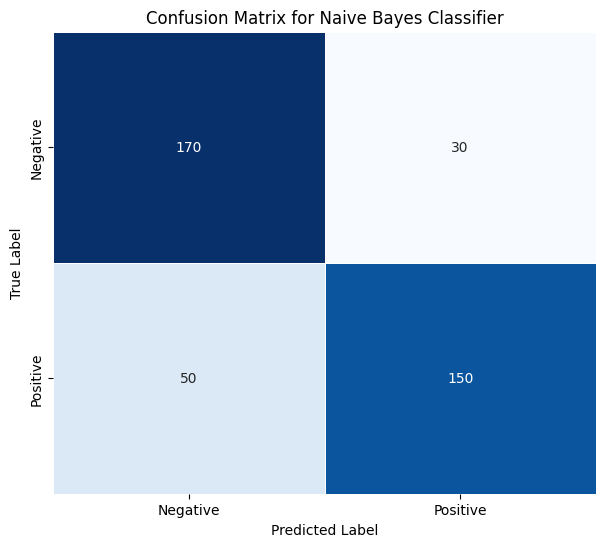

In [ ]:
model = MultinomialNB()

# Train the model
model.fit(X_train_vec, y_train)
print("Model training complete")

# Make prediction on the test set
y_pred = model.predict(X_test_vec)

# Accuracy paramters
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
# Labels 0=Negative, 1=Positive
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

# Visualization
print("\nVisualizing Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, cbar=False)
plt.title('Confusion Matrix for Naive Bayes Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Feature importance visualization

/tmp/ipython-input-1149463816.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neg_scores), y=list(neg_features), ax=axes[0], palette="Reds_d")
/tmp/ipython-input-1149463816.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_scores), y=list(pos_features), ax=axes[1], palette="Greens_d")


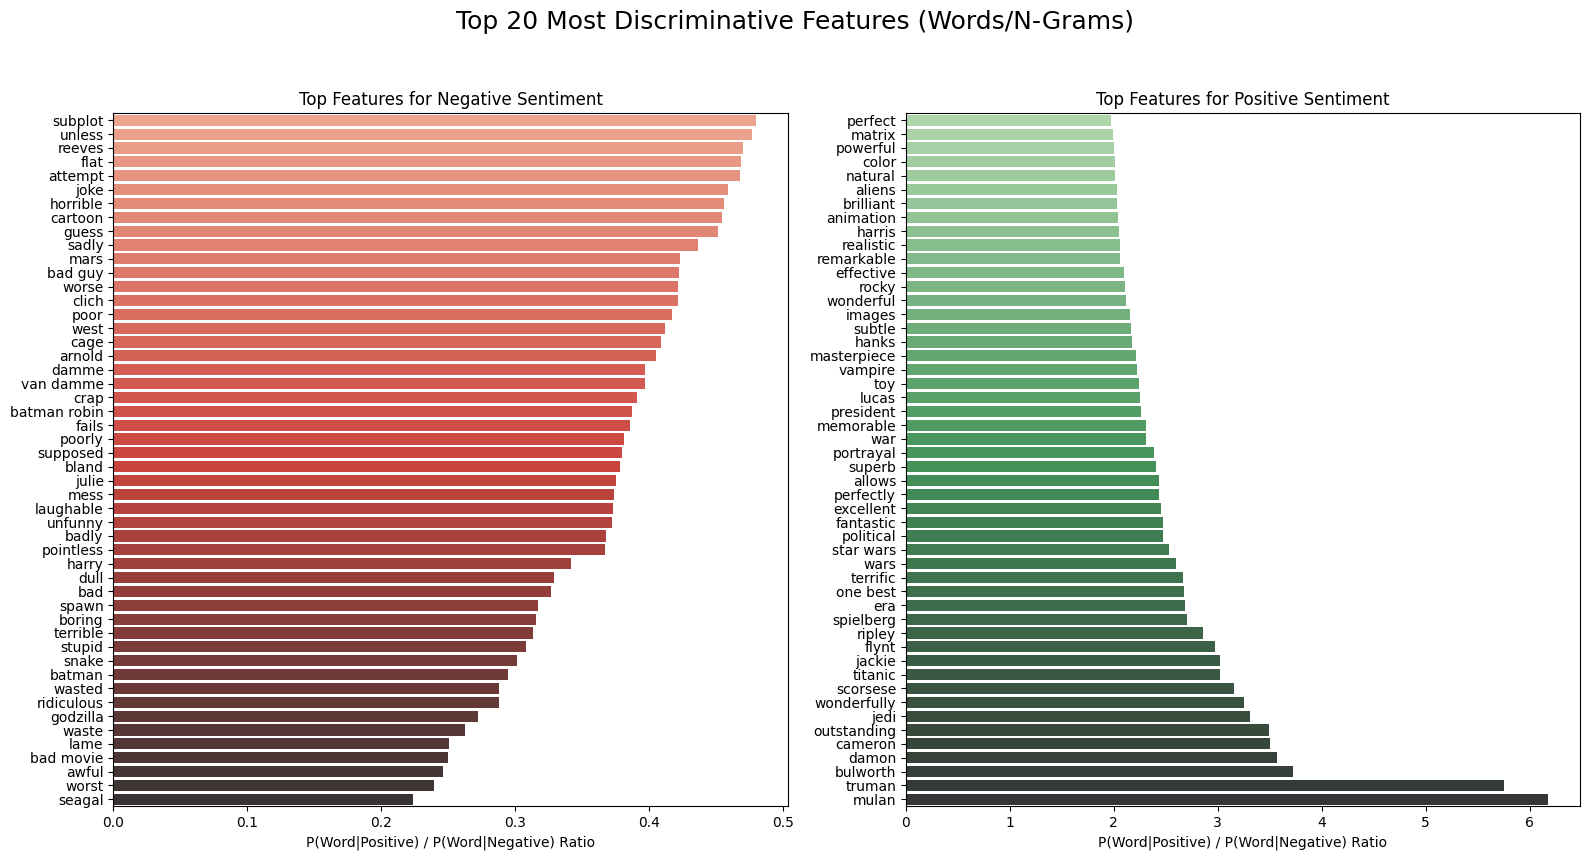

In [ ]:
# --- Visualization 2: Top Discriminative Features ---
def get_top_n_features(vectorizer, model, n=50):
  """
  Shows the top N features (words/n-grams) that are most predictive for
  positive and negative sentiment based on the model's coefficients.
  """
  feature_names = vectorizer.get_feature_names_out()

  # Extract feature log probabilities (Coefficients) for Naive Bayes
  # log_prob[0] is for class 0 (Negative), log_prob[1] is for class 1 (Positive)
  neg_scores = model.feature_log_prob_[0]
  pos_scores = model.feature_log_prob_[1]

  # Calculate the ratio (Positive importance / Negative importance)
  # This helps find words that are *disproportionately* associated with a class
  # Using np.exp to convert log probabilities back to probabilities for ratio calculation
  score_diff = np.exp(pos_scores) / np.exp(neg_scores)

  # Extract most positive score words (features) and most negative score words (features) very important step
  sorted_neg_indices = np.argsort(score_diff)[:n]
  top_neg_features = [(feature_names[i], score_diff[i]) for i in sorted_neg_indices]

  sorted_pos_indices = np.argsort(score_diff)[-n:]
  top_pos_features = [(feature_names[i], score_diff[i]) for i in sorted_pos_indices]

  return top_neg_features, top_pos_features

top_neg, top_pos =  get_top_n_features(vectorizer, model, n=50)

# Plotting the features
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
fig.suptitle('Top 20 Most Discriminative Features (Words/N-Grams)', fontsize=18)

# Negative Plot
neg_features, neg_scores = zip(*top_neg)
# Reverse the order for better visualization (most negative at the top)
neg_features = neg_features[::-1]
neg_scores = neg_scores[::-1]
sns.barplot(x=list(neg_scores), y=list(neg_features), ax=axes[0], palette="Reds_d")
axes[0].set_title('Top Features for Negative Sentiment')
axes[0].set_xlabel('P(Word|Positive) / P(Word|Negative) Ratio')

# Positive Plot
pos_features, pos_scores = zip(*top_pos)
sns.barplot(x=list(pos_scores), y=list(pos_features), ax=axes[1], palette="Greens_d")
axes[1].set_title('Top Features for Positive Sentiment')
axes[1].set_xlabel('P(Word|Positive) / P(Word|Negative) Ratio')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### Testing with Cutom Input

In [ ]:
def predict_sentiment(text, vectorizor, model):
  # Prepare vector for the new document or text
  new_text_vec = vectorizer.transform([text])

  # predict the sentiment class of for the new document or text
  predcition = model.predict(new_text_vec)[0]

  # Predict the probabilities for each class
  probabilities = model.predict_proba(new_text_vec)[0]

  sentiment_label = "Positive" if predcition == 1 else "Negative"

  return sentiment_label, probabilities

print("="*100)
print("WATCH OUT !!! We are testing all the sentiment probablities against the positive probablity.")
print("="*100)

# Example 1: Strongly Positive . Give new text input and see the sentiments for checking postive sentiment
test_review_pos = "This movie was absolutely brilliant, the acting was superb and the ending was a masterpiece. A definite must-see!"
# test_review_pos = "Movie was classic demonstration of patritism. Simplry great cinematography. Superb cast. I will surely recommend this moview."
label_pos, prob_pos = predict_sentiment(test_review_pos, vectorizer, model)
print(f"Review by user: '{test_review_pos}'")
print(f"Predicted Sentiment: {label_pos} (Positive Prob: {prob_pos[1]:.4f})") # Watchout for the index of the prob_pos[] array I have used 1 because we are suppose to test it against Positive

# Example 2: Strongly negative review test
test_review_neg = "The plot was a total mess, the actors were wooden, and I hated every minute of this terrible cinematic disaster."
label_neg, prob_neg = predict_sentiment(test_review_neg, vectorizer, model)
print(f"\nReview by user: '{test_review_neg}'")
print(f"Predicted Sentiment: {label_neg} (Positive Prob: {prob_neg[1]:.4f})")

# Example 3: Neutral/Mixed
test_review_mixed = "The film was okay, but the soundtrack was really annoying. I wouldn't recommend it."
label_mixed, prob_mixed = predict_sentiment(test_review_mixed, vectorizer, model)
print(f"\nReview: '{test_review_mixed}'")
print(f"Predicted Sentiment: {label_mixed} (Positive Prob: {prob_mixed[1]:.4f})")


WATCH OUT !!! We are testing all the sentiment probablities against the positive probablity.
Review by user: 'This movie was absolutely brilliant, the acting was superb and the ending was a masterpiece. A definite must-see!'
Predicted Sentiment: Positive (Positive Prob: 0.7259)

Review by user: 'The plot was a total mess, the actors were wooden, and I hated every minute of this terrible cinematic disaster.'
Predicted Sentiment: Negative (Positive Prob: 0.1914)

Review: 'The film was okay, but the soundtrack was really annoying. I wouldn't recommend it.'
Predicted Sentiment: Negative (Positive Prob: 0.4428)
